In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
#for array manipulations
import numpy as np
import pandas as pd
#for image processing
import cv2 
#for displaying images
import matplotlib.pyplot as plt
#to display images in this notebook, not in a separate window
%matplotlib inline
#to access system resources such as directories
import os
#This wilallow us to get the training time of each model
import time

In [3]:
os.getcwd()

'C:\\Users\\USER\\Documents\\GitHub\\maize-disease-detection\\notebooks'

In [4]:
#set our base directory. This should point to the location of the plant-diseases folder
base_dir = 'C:\\Users\\USER\\Documents\\GitHub\\maize-disease-detection'
data_folder = os.path.join(base_dir, 'data')
maize_data_folder = os.path.join(data_folder, 'maize')

In [6]:
#This function loads 32 images of a particular disease
def get_32(disease):
    '''
    disease:
        A string that could be common_rust, healthy, leaf_spot, nothern_leaf_blight
    ........
    disease_images:
        A list of images for the selected disease
    '''
    #this list will contain the 20 images returned
    disease_images = []
    #path to the images
    disease_images_path = os.path.join(maize_data_folder, disease)
    for image_path in os.listdir(disease_images_path):
        image_path = os.path.join(disease_images_path, image_path)
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        disease_images.append(image)
    return disease_images

#This function will help us plot 10 images
def plot_images(images, title):
    '''
    images: List
        List of images
    title: String
        Title for each image i.e name of disease
    '''
    plt.figure(figsize=(15,6))
    for i in range(10):
        plt.subplot(2,5, i+1)
        plt.imshow(images[i])
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
#This function generates ORB features
def extract_features_orb(image, vector_size=32):
    try:
        feature_generator = cv2.ORB_create()
        orb_keypoints = feature_generator.detect(image)
        orb_keypoints = orb_keypoints[:32]
        orb_keypoints, orb_descriptors = feature_generator.compute(image, orb_keypoints)
        orb_descriptors = orb_descriptors.flatten()
        #The descriptor vector size is 128
        needed_size = (vector_size*128)
        if orb_descriptors.size < needed_size:
            #If we have less than 32 keypoints, add zeros to the end of our vector
            orb_descriptors = np.concatenate([orb_descriptors, np.zeros(needed_size - orb_descriptors.size)])
    except cv2.error as e:
        print(f'Error: {e}')
        return None
    return orb_descriptors

#This function generates KAZE features
def extract_features_kaze(image, vector_size=32):
    try:
        feature_generator = cv2.KAZE_create()
        kaze_keypoints = feature_generator.detect(image)
        kaze_keypoints = kaze_keypoints[:32]
        kaze_keypoints, kaze_descriptors = feature_generator.compute(image, kaze_keypoints)
        kaze_descriptors = kaze_descriptors.flatten()
        #The descriptor vector size is 128
        needed_size = (vector_size*128)
        if kaze_descriptors.size < needed_size:
            #If we have less than 32 keypoints, add zeros to the end of our vector
            kaze_descriptors = np.concatenate([kaze_descriptors, np.zeros(needed_size - kaze_descriptors.size)])
    except cv2.error as e:
        print(f'Error: {e}')
        return None
    return kaze_descriptors

def extract_features_hog(image, feature_size=4096):
    hog = cv2.HOGDescriptor()
    features = hog.compute(image)
    required_features = features[:feature_size].ravel()
    return required_features

#Let us extraxt KAZE features
def extract_features(algorithm=0):
    '''
    Algorithm:
        1 for ORB
        0 for KAZE
        2 for HOG
    '''
    #Now let us perform these steps for all the 32 images loaded
    #This will contain all our images
    all_images = []
    #This will contain all our labels
    all_labels = []
    labels = ['common_rust', 'healthy', 'leaf_spot', 'nothern_leaf_blight']
    for i, image_folder in enumerate([common_rust_images, healthy_images, leaf_spot_images, nothern_leaf_blight_images]):
        for image in image_folder:
            all_images.append(image)
            all_labels.append(labels[i])
    features, labels = [], []
    for i, image in enumerate(all_images):
        image_features = []
        try:
            if algorithm == 1:
                image_features = extract_features_orb(image)
            elif algorithm == 0:
                image_features = extract_features_kaze(image)
            else:
                image_features = extract_features_hog(image)
            image_label = all_labels[i]
            features.append(image_features)
            labels.append(image_label)
        except AttributeError as e:
            print(e)
    features = np.array(features)
    labels = np.array(labels)
    features = StandardScaler().fit_transform(features)
    labels = LabelEncoder().fit_transform(labels)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3)
    
    return X_train, X_test, y_train, y_test

#Let us extraxt KAZE features
def extract_features2(algorithm=0):
    '''
    Algorithm:
        1 for ORB
        0 for KAZE
        2 for HOG
    '''
    #Now let us perform these steps for all the 32 images loaded
    #This will contain all our images
    all_images = []
    #This will contain all our labels
    all_labels = []
    labels = ['common_rust', 'healthy', 'leaf_spot', 'nothern_leaf_blight']
    for i, image_folder in enumerate([common_rust_images, healthy_images, leaf_spot_images, nothern_leaf_blight_images]):
        for image in image_folder:
            all_images.append(image)
            all_labels.append(labels[i])
    features, labels = [], []
    for i, image in enumerate(all_images):
        image_features = []
        try:
            if algorithm == 1:
                image_features = extract_features_orb(image)
            elif algorithm == 0:
                image_features = extract_features_kaze(image)
            else:
                image_features = extract_features_hog(image)
            image_label = all_labels[i]
            features.append(image_features)
            labels.append(image_label)
        except AttributeError as e:
            print(e)
    features = np.array(features)
    labels = np.array(labels)
    features = StandardScaler().fit_transform(features)
    labels = LabelEncoder().fit_transform(labels)
    
    return features, labels

#This method gives us a rough idea about the accuracy of the base models and their raining times
def train_base_models(X_train, y_train, X_test, y_test):
    '''
    '''
    model_accuracy = []
    train_time = []
    model_names = []
    for i, classifier in enumerate(models):
        try:
            #Let us train the model and get the training time
            start_time = time.time()
            classifier.fit(X_train, y_train)
            stop_time = time.time()
            train_time.append(stop_time - start_time)
            predictions = classifier.predict(X_test)
            accuracy = accuracy_score(y_test, predictions)
            model_accuracy.append(round(accuracy, 3))
            model_names.append(names[i])
            print(f'{names[i]}: {round(accuracy, 3)}')
        except Exception as e:
            print(f'Could not train {names[i]} because of {e}')
    df = pd.DataFrame({'Model':model_names, 'Accuracy':model_accuracy, 'Train Time':train_time})
    df = df.sort_values(by=['Accuracy'], ascending=False)
    return df

#This method gives us a rough idea about the accuracy of the base models and their raining times
def train_base_models2(features, labels):
    '''
    '''
    #We use cross-validation
    model_accuracy = []
    train_time = []
    model_names = []
    
    for i, classifier in enumerate(models):
        try:
            #Let us train the model and get the training time
            start_time = time.time()
            scores = cross_val_score(classifier, features, labels, scoring='accuracy', cv=10)
            stop_time = time.time()
            train_time.append(stop_time - start_time)
            model_accuracy.append(round(np.mean(scores), 3))
            model_names.append(names[i])
            print(f'{names[i]}: {round(np.mean(scores), 3)}')
        except Exception as e:
            print(f'Could not train {names[i]} because of {e}')
    df = pd.DataFrame({'Model':model_names, 'Accuracy':model_accuracy, 'Train Time':train_time})
    df = df.sort_values(by=['Accuracy'], ascending=False)
    return df

#This function returns the model perfomance on kaze data
def kaze_results(algorithm=0):
    models_names = []
    model_perfomance = []
    train_time = []
    for i, model in enumerate(kaze_models):
        start = time.time()
        scores = cross_val_score(model, X,y, scoring='accuracy', cv=10)
        stop = time.time()
        models_names.append(model_names[i])
        model_perfomance.append(round(scores.mean(), 2))
        train_time.append((stop - start)/10)
    df = pd.DataFrame({'Model Name':models_names, 'Model Accuracy':model_perfomance, 'Training time':train_time})
    df = df.sort_values(by=['Model Accuracy'], ascending=False)
    return df

#This function returns the model perfomance on hog data
def hog_results(X,y):
    models_names = []
    model_perfomance = []
    train_time = []
    for i, model in enumerate(hog_models):
        start = time.time()
        scores = cross_val_score(model, X, y, scoring='accuracy', cv=10)
        stop = time.time()
        models_names.append(model_names[i])
        model_perfomance.append(round(scores.mean(), 2))
        train_time.append((stop - start)/10)
    df = pd.DataFrame({'Model Name':models_names, 'Model Accuracy':model_perfomance, 'Training Time':train_time})
    df = df.sort_values(by=['Model Accuracy', 'Training Time'], ascending=False)
    return df

In [8]:
common_rust_images = get_32('common_rust')
healthy_images = get_32('healthy')
leaf_spot_images = get_32('leaf_spot')
nothern_leaf_blight_images = get_32('nothern_leaf_blight')

In [17]:
hog_random_forest = RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features=100,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
hog_logistic_regression = LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.1, verbose=0,
                   warm_start=False)
hog_knearest_neighbors = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=1,
                     weights='distance')
hog_linear_svc = LinearSVC(C=0.0001, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.01,
          verbose=0)
hog_svc = SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True, tol=0.1,
    verbose=False)
hog_models = [
    hog_random_forest,
    hog_logistic_regression,
    hog_knearest_neighbors,
    hog_linear_svc,
    hog_svc
]
model_names = [
    'Random Forest',
    'Logistic Regression',
    'K-Nearest Neighbor',
    'Linear SVC',
    'Support Vector Classifier'
]

In [13]:
X, y = extract_features2(algorithm=2)

In [14]:
X.shape, y.shape

((128, 4096), (128,))

In [16]:
kfold = KFold(n_splits=10)

In [20]:
rfecv = RFECV(estimator=hog_logistic_regression, step=1, cv=kfold, scoring='accuracy')
rfecv.fit(X,y)

RFECV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
      estimator=LogisticRegression(C=0.5, class_weight=None, dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=200,
                                   multi_class='auto', n_jobs=None,
                                   penalty='l2', random_state=None,
                                   solver='lbfgs', tol=0.1, verbose=0,
                                   warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [21]:
rfecv.grid_scores_

array([0.25384615, 0.37692308, 0.37820513, ..., 0.61346154, 0.62115385,
       0.61346154])

In [22]:
rfecv.ranking_

array([ 651,    1,    1, ..., 1317,  835, 1064])

In [23]:
rfecv.support_

array([False,  True,  True, ..., False, False, False])

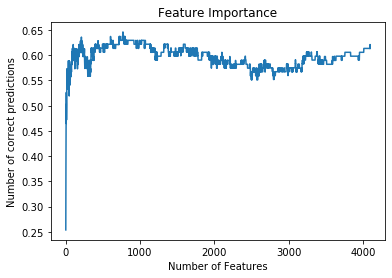

In [27]:
plt.figure()
plt.title('Feature Importance')
plt.xlabel('Number of Features')
plt.ylabel('Number of correct predictions')
plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_)
plt.show()

In [40]:
rfecv.support_[0]

False

In [42]:
features = []
feature_importance = rfecv.support_
new_features = []
new_labels = []

for i,feature in enumerate(feature_importance):
    if feature:
        new_features.append(i)

In [43]:
#The number of columns that act as usefule features
len(new_features)

767

In [45]:
#These are the columns chosen
new_features[:30]

[1,
 2,
 3,
 5,
 6,
 10,
 11,
 12,
 14,
 15,
 17,
 19,
 20,
 21,
 28,
 29,
 30,
 35,
 37,
 38,
 39,
 41,
 44,
 46,
 47,
 48,
 51,
 52,
 56,
 57]

In [29]:
knn_rfecv = RFECV(estimator=hog_linear_svc, step=1, cv=kfold, scoring='accuracy')
knn_rfecv.fit(X,y)

RFECV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
      estimator=LinearSVC(C=0.0001, class_weight=None, dual=True,
                          fit_intercept=True, intercept_scaling=1,
                          loss='squared_hinge', max_iter=1000,
                          multi_class='ovr', penalty='l2', random_state=None,
                          tol=0.01, verbose=0),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [30]:
knn_rfecv.grid_scores_

array([0.06923077, 0.13076923, 0.14615385, ..., 0.64807692, 0.64807692,
       0.64807692])

In [31]:
knn_rfecv.ranking_

array([  1,   1,   1, ..., 337, 883,   1])

In [32]:
knn_rfecv.support_

array([ True,  True,  True, ..., False, False,  True])

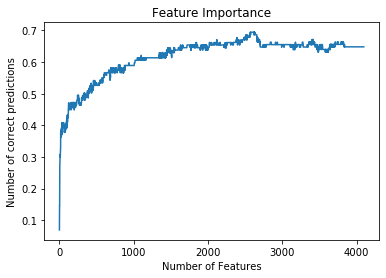

In [33]:
plt.figure()
plt.title('Feature Importance')
plt.xlabel('Number of Features')
plt.ylabel('Number of correct predictions')
plt.plot(range(1, len(knn_rfecv.grid_scores_)+1), knn_rfecv.grid_scores_)
plt.show()

In [34]:
svc_rfecv = RFECV(estimator=hog_svc, step=1, cv=kfold, scoring='accuracy')
svc_rfecv.fit(X,y)

RFECV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
      estimator=SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None,
                    coef0=0.0, decision_function_shape='ovr', degree=3,
                    gamma='scale', kernel='linear', max_iter=-1,
                    probability=False, random_state=None, shrinking=True,
                    tol=0.1, verbose=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [35]:
svc_rfecv.grid_scores_

array([0.04615385, 0.12307692, 0.18461538, ..., 0.58397436, 0.59230769,
       0.59230769])

In [37]:
svc_rfecv.ranking_

array([ 504,  592,    1, ..., 1752, 1427,  202])

In [38]:
svc_rfecv.support_

array([False, False,  True, ..., False, False, False])

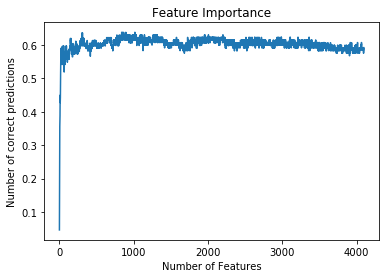

In [39]:
plt.figure()
plt.title('Feature Importance')
plt.xlabel('Number of Features')
plt.ylabel('Number of correct predictions')
plt.plot(range(1, len(svc_rfecv.grid_scores_)+1), svc_rfecv.grid_scores_)
plt.show()